# LEBRON VS JORDAN PREDICTION



## ANALISIS DE LOS DATOS


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc, recall_score, precision_score
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix



import warnings
warnings.filterwarnings('ignore')
    
# import some data to play with
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

jordan_dataset = load_dataset('data/jordan_career.csv')
lebron_dataset = load_dataset('data/lebron_career.csv')


# Take the first two features. We could avoid this by using a two-dim dataset
#data = dataset.values


In [2]:
def check_dataframe(dataframe):
    print('############### DTYPES ###############')
    print(dataframe.dtypes)
    print('############### HEAD ###############')
    print(dataframe.head(5))
    print('############### NaN ###############')
    print(dataframe.isnull().sum())
    print('############### TAIL ###############')
    print(dataframe.tail(5))
    print('############### INFO ###############')
    print(dataframe.info())

In [3]:
check_dataframe(jordan_dataset)

############### DTYPES ###############
game            int64
date           object
age            object
team           object
opp            object
result         object
mp             object
fg              int64
fga             int64
fgp           float64
three           int64
threeatt        int64
threep        float64
ft              int64
fta             int64
ftp           float64
orb             int64
drb             int64
trb             int64
ast             int64
stl             int64
blk             int64
tov             int64
pts             int64
game_score    float64
minus_plus    float64
dtype: object
############### HEAD ###############
   game        date     age team  opp   result     mp  fg  fga    fgp  ...  \
0     1  1984-10-26  21-252  CHI  WSB  W (+16)  40:00   5   16  0.313  ...   
1     2  1984-10-27  21-253  CHI  MIL   L (-2)  34:00   8   13  0.615  ...   
2     3  1984-10-29  21-255  CHI  MIL   W (+6)  34:00  13   24  0.542  ...   
3     4  1984-10-30  21-25

In [4]:
#REMOVE COLUMN MINUS PLUS AND REPLACE ALL NAN FOR FLOAT OF 0.0
jordan_dataset = jordan_dataset.drop(['minus_plus'], axis=1)
jordan_dataset = jordan_dataset.drop(['date'], axis=1)
jordan_dataset['threep'].fillna(0.0, inplace=True)
jordan_dataset['ftp'].fillna(0.0, inplace=True)


In [5]:
jordan_dataset['result'] = jordan_dataset['result'].str[:1]
jordan_dataset["mp"] = jordan_dataset["mp"].apply(lambda x: float(str(x).replace(":",".").split(",")[0].strip()))
jordan_dataset["age"] = jordan_dataset["age"].apply(lambda x: float(str(x).replace("-",".").split(",")[0].strip()))

In [6]:
jordan_dataset.head()

,game,age,team,opp,result,mp,fg,fga,fgp,three,...,ftp,orb,drb,trb,ast,stl,blk,tov,pts,game_score
0,1,21.252,CHI,WSB,W,40.0,5,16,0.313,0,...,0.857,1,5,6,7,2,4,5,16,12.5
1,2,21.253,CHI,MIL,L,34.0,8,13,0.615,0,...,1.000,3,2,5,5,2,1,3,21,19.4
2,3,21.255,CHI,MIL,W,34.0,13,24,0.542,0,...,0.846,2,2,4,5,6,2,3,37,32.9
3,4,21.256,CHI,KCK,W,36.0,8,21,0.381,0,...,1.000,2,2,4,5,3,1,6,25,14.7
4,5,21.258,CHI,DEN,L,33.0,7,15,0.467,0,...,0.750,3,2,5,5,1,1,2,17,13.2


<AxesSubplot: xlabel='age', ylabel='Density'>

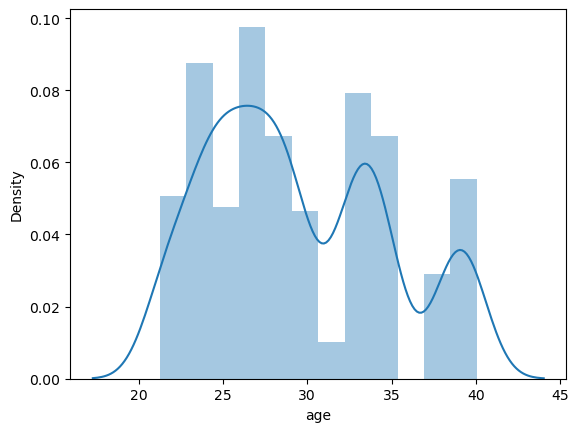

In [25]:
sns.distplot(jordan_dataset['age'])

<AxesSubplot: xlabel='result', ylabel='count'>

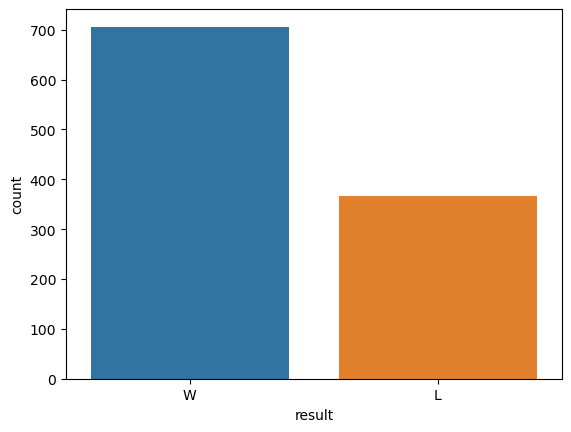

In [8]:
sns.countplot(x=jordan_dataset["result"])

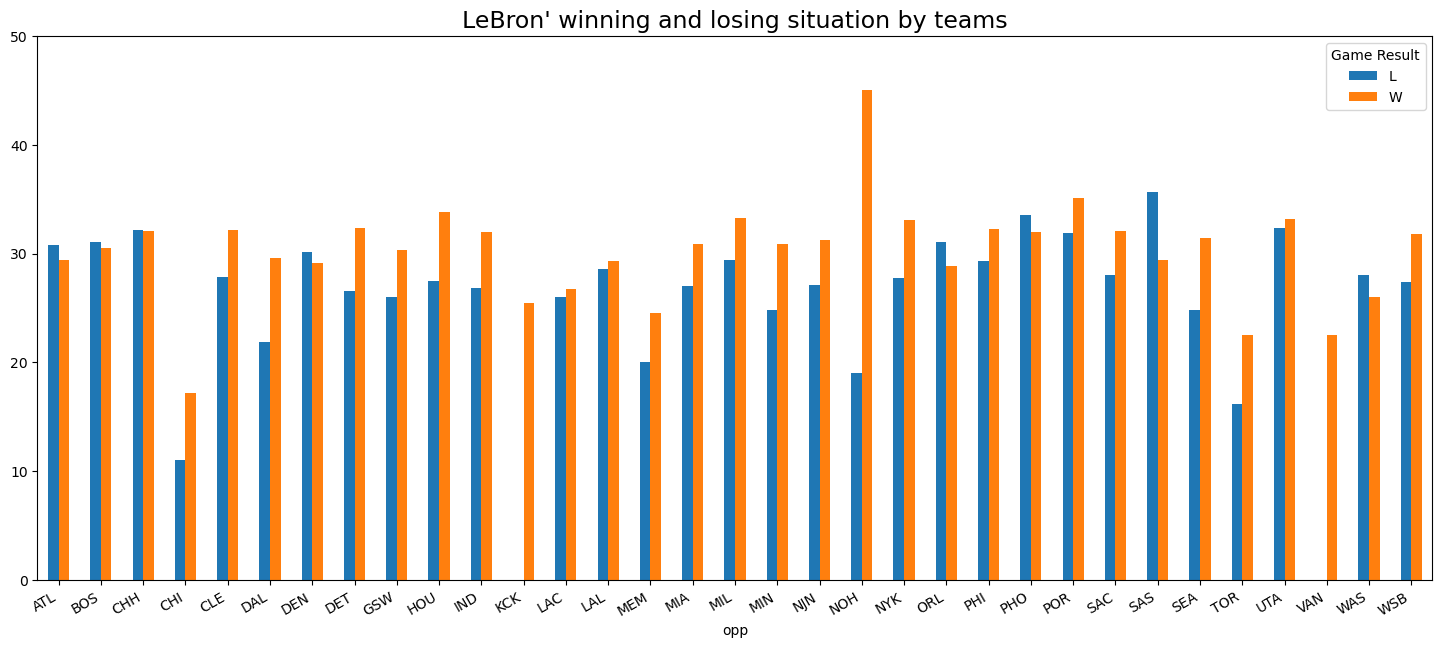

In [9]:
def plotPointsDependsOpp(dataframe):
    fig, ax = plt.subplots(figsize=(18,8))

    opp = dataframe.pivot_table(columns='result',index='opp', values='pts')
    opp.plot(ax=ax, kind='bar')

    ax.set_ylim(0, 50)
    ax.set_title("LeBron' winning and losing situation by teams", fontsize=17)
    ax.legend(loc='upper right', title='Game Result')

    fig.autofmt_xdate()

plotPointsDependsOpp(jordan_dataset)

### categorizar valores


In [10]:
print("####### JORDAN TEAMS ############")
print(jordan_dataset['team'].unique())
print("####### LEBRON TEAMS ############")
print(lebron_dataset['team'].unique())

####### JORDAN TEAMS ############
['CHI' 'WAS']
####### LEBRON TEAMS ############
['CLE' 'MIA']


In [11]:
mappingResult = {'W': 1, 'L': 0}
jordan_dataset = jordan_dataset.replace({'result': mappingResult})

mappingResult = {'CHI': 1, 'WAS': 0}
jordan_dataset = jordan_dataset.replace({'team': mappingResult})

In [12]:
def replace_categorical(df):
    columns = df.columns
    for col in columns:
        if df[col].dtype == 'object':
            df = pd.concat([df, pd.get_dummies(df[col],prefix=col)], axis=1)
            df = df.drop(columns=col)
    return df

In [13]:
#jordan_dataset = jordan_dataset.drop(['team'], axis=1)
jordan_dataset = jordan_dataset.drop(['opp'], axis=1)

In [14]:
jordan_dataset.head()

,game,age,team,result,mp,fg,fga,fgp,three,threeatt,...,ftp,orb,drb,trb,ast,stl,blk,tov,pts,game_score
0,1,21.252,1,1,40.0,5,16,0.313,0,0,...,0.857,1,5,6,7,2,4,5,16,12.5
1,2,21.253,1,0,34.0,8,13,0.615,0,0,...,1.000,3,2,5,5,2,1,3,21,19.4
2,3,21.255,1,1,34.0,13,24,0.542,0,0,...,0.846,2,2,4,5,6,2,3,37,32.9
3,4,21.256,1,1,36.0,8,21,0.381,0,0,...,1.000,2,2,4,5,3,1,6,25,14.7
4,5,21.258,1,0,33.0,7,15,0.467,0,0,...,0.750,3,2,5,5,1,1,2,17,13.2


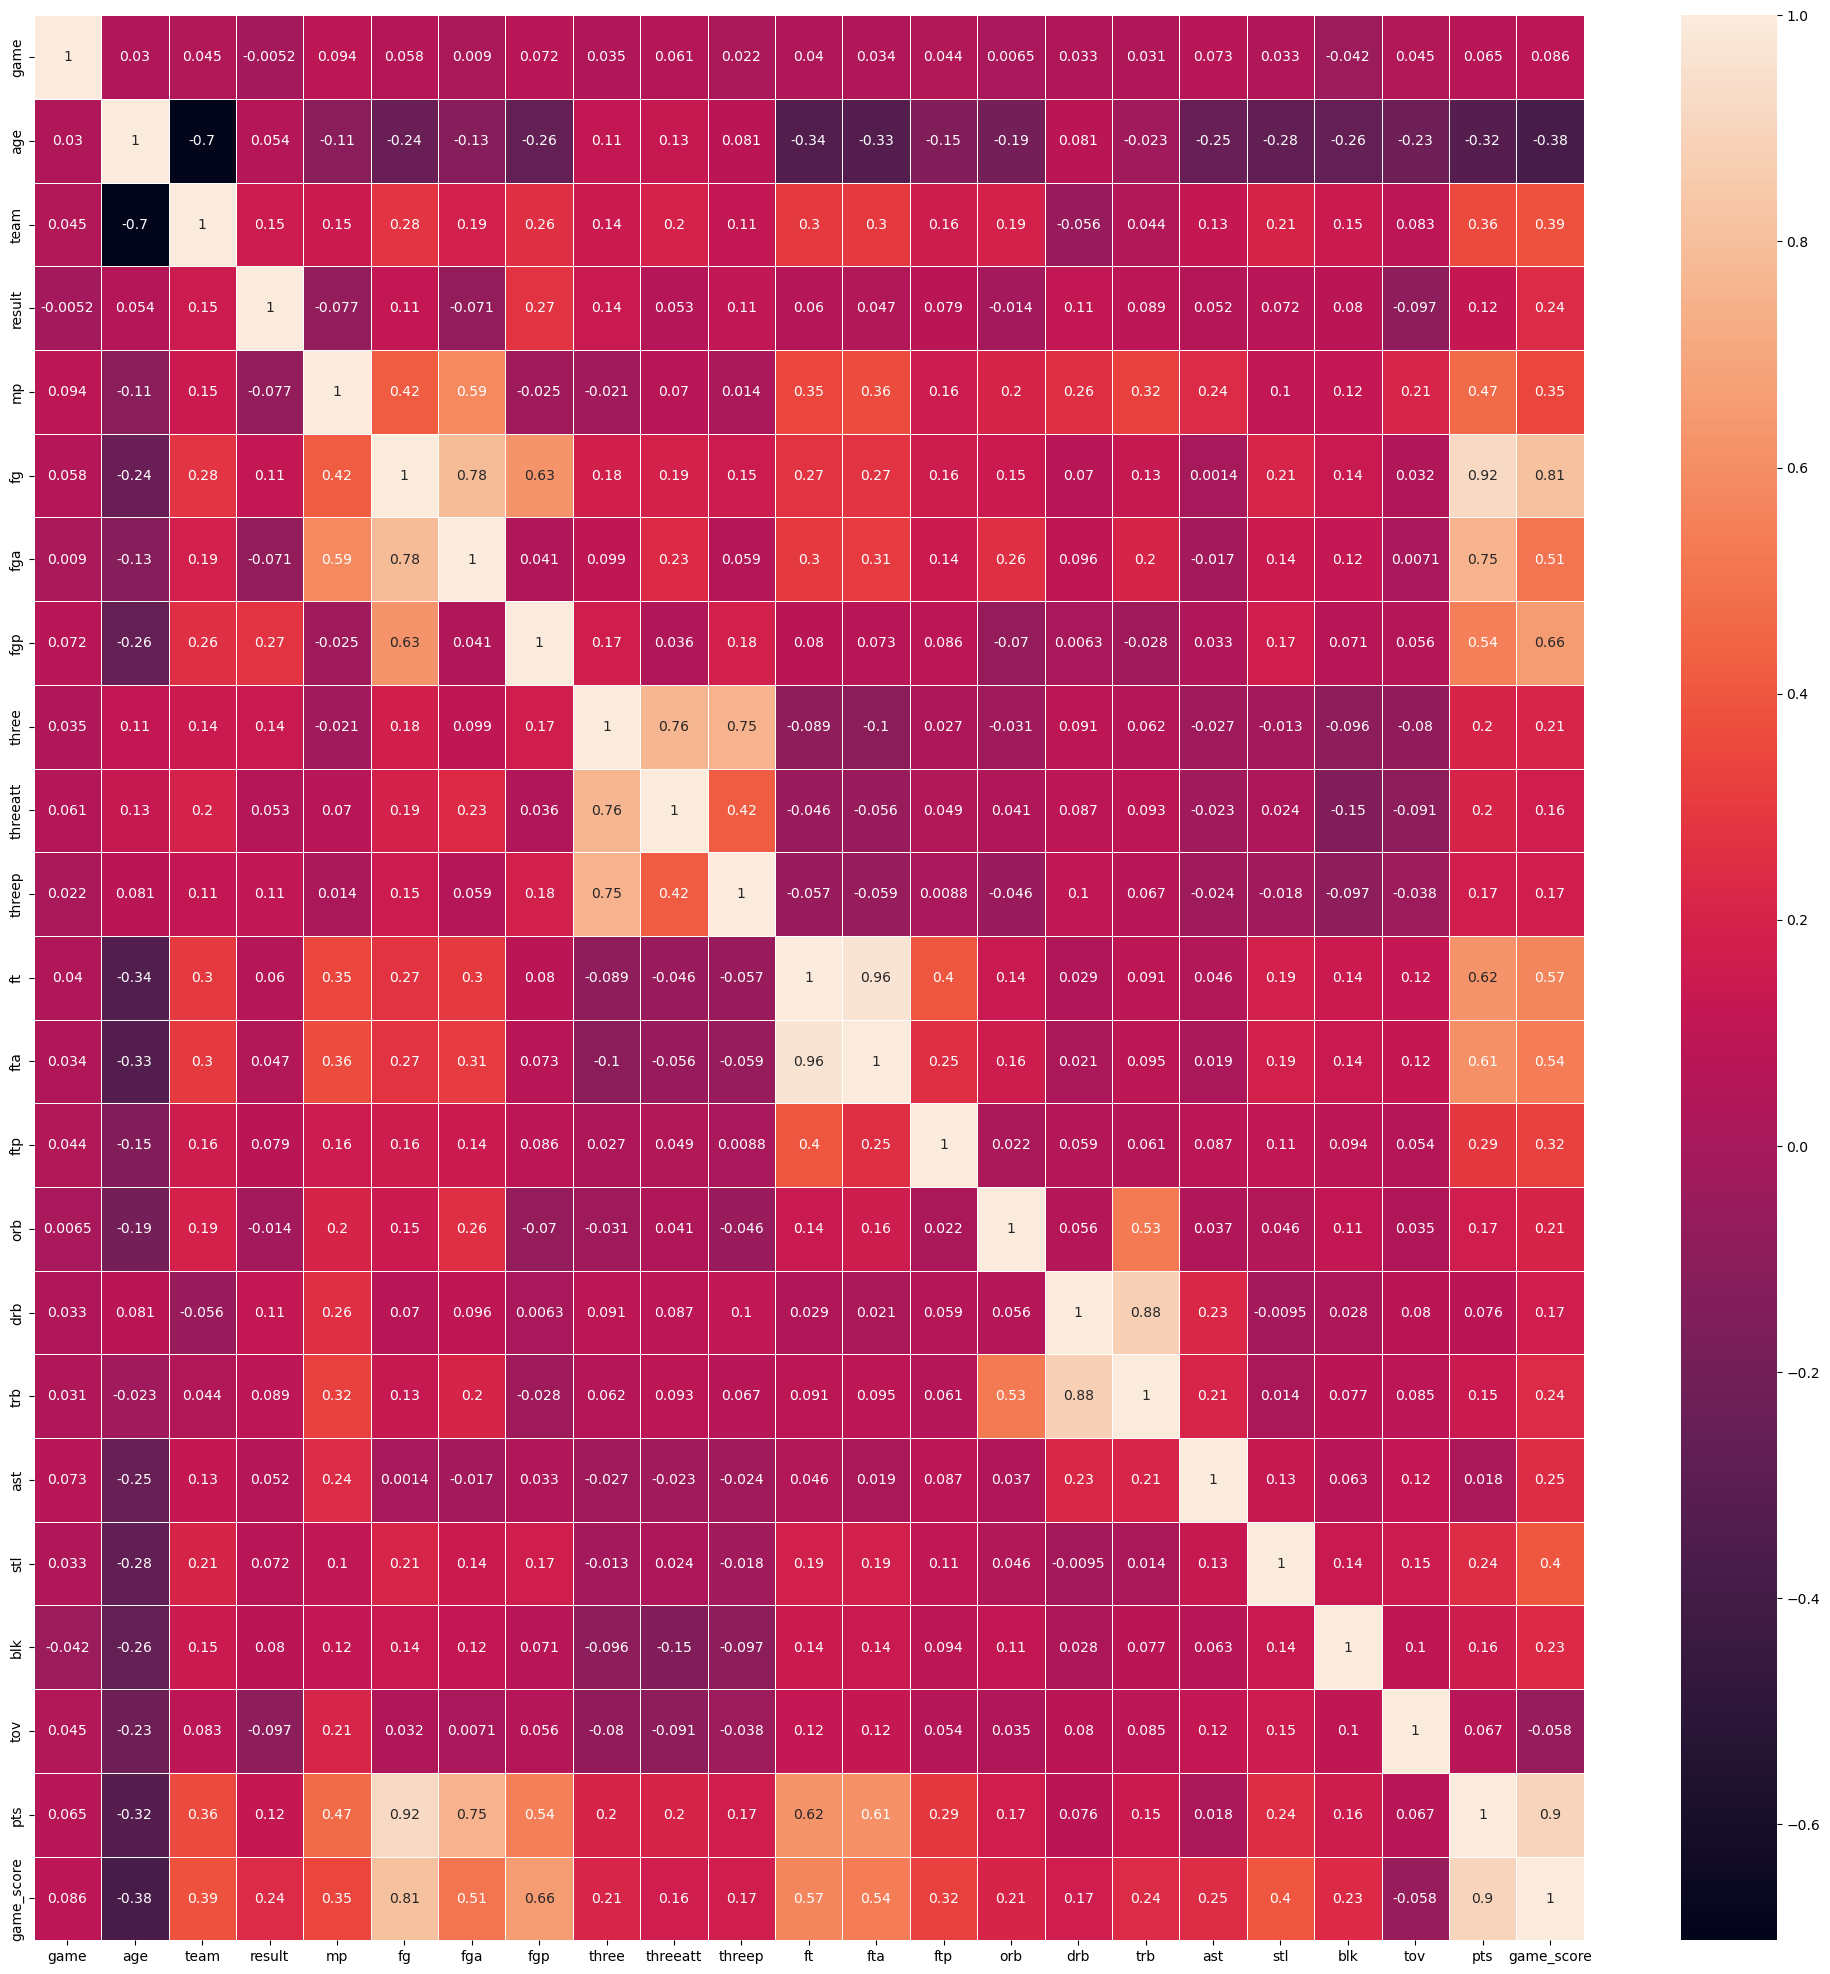

In [15]:
correlacio = jordan_dataset.corr()
plt.figure(figsize=(25,25))
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)


In [45]:
features = ["fg","fgp", "ft", "fta","threeatt","stl","pts", "game_score"] 
X_jordan = jordan_dataset.loc[:, features] 
y_jordan = jordan_dataset.loc[:, 'team'] 

In [46]:
import time

def create_confusionMatrix(true_class, preds, model_name):
    conf_matrix = confusion_matrix(y_true=true_class, y_pred=preds)
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    model_filename = model_name.replace(' ', '_')
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
    plt.title('{} Confusion Matrix'.format(model_name))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    plt.savefig("figures/{}_confusion_matrix.png".format(model_filename))
    plt.show() 
    
    

def hyperparametresForModels(name, model, params, X_train, X_test, y_train, y_test):
    gs = GridSearchCV(estimator=model, param_grid=params) #Search Hyper parametre 
    initialTime = time.time()
    gs.fit(X_train, y_train)
    print("MODEL ", name )
    print("{} Best Params: {}".format(name, gs.best_params_))
    print("{} Training score with best params: {}".format(name, gs.best_estimator_.score(X_train, y_train)))
    print("{} Test score with best params: {}".format(name, gs.best_estimator_.score(X_test, y_test)))
    y_preds = gs.best_estimator_.predict(X_test)
    print("{} prediction metrics: \n{}".format(name, classification_report(y_true=y_test, y_pred=y_preds)))
    scores = cross_val_score(model, X_train, y_train, cv=6, scoring='accuracy')
    print("Cross-validation scores:", scores)
    print("Mean:", scores.mean())
    create_confusionMatrix(y_test, y_preds, name)
    finalTime = time.time()- initialTime
    print("Time:", finalTime)


In [47]:
def logisticRegression(X_train, X_test, y_train, y_test):
    logisticRegression = LogisticRegression(fit_intercept=True, tol=0.001 ,class_weight='balanced')

    lr_params = {
        'C': [0.1, 1.0, 10.0, 100.0, 1000.0],
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'solver': ['lbfgs', 'sag', 'saga']
    }
    hyperparametresForModels('Logistic Regression', logisticRegression, lr_params, X_train, X_test, y_train, y_test) 

In [48]:
def svc(X_train, X_test, y_train, y_test):
    svc_kernel = SVC(probability=True, max_iter = 100000, class_weight='balanced')

    svc_params = {
        'C': [0.1, 1, 10, 100, 1000],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [3, 4, 5]
    }

    hyperparametresForModels('SVC ', svc_kernel, svc_params, X_train, X_test, y_train, y_test)

In [49]:
def knn(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier()
    knn_params = {
        'n_neighbors': [1, 2, 5, 10, 20, 40],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }
    hyperparametresForModels('KNN ', knn,knn_params, X_train, X_test, y_train, y_test)

In [50]:
def rfc(X_train, X_test, y_train, y_test):
    rfc = RandomForestClassifier(class_weight='balanced')

    rfc_params = {
        'n_estimators': [100, 200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [4, 5, 6, 7, 8, 9],
        'criterion': ['gini', 'entropy']
    }
    hyperparametresForModels('Random Forest Classifier', rfc,rfc_params, X_train, X_test, y_train, y_test)

#### SIN ESTANDARIZAR Y MODELOS DE PREDICION


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_jordan, y_jordan, train_size=0.8, random_state=40)

MODEL  Logistic Regression
Logistic Regression Best Params: {'C': 1.0, 'penalty': 'l2', 'solver': 'sag'}
Logistic Regression Training score with best params: 0.7817969661610268
Logistic Regression Test score with best params: 0.7395348837209302
Logistic Regression prediction metrics: 
              precision    recall  f1-score   support

           0       0.26      0.75      0.39        24
           1       0.96      0.74      0.83       191

    accuracy                           0.74       215
   macro avg       0.61      0.74      0.61       215
weighted avg       0.88      0.74      0.78       215

Cross-validation scores: [0.6993007  0.83916084 0.83216783 0.73426573 0.77622378 0.77464789]
Mean: 0.7759611280738041


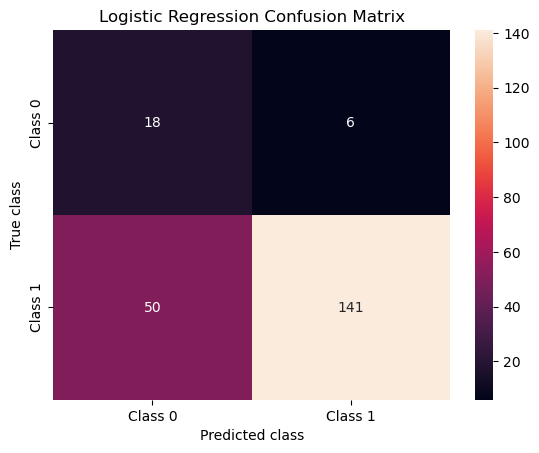

<Figure size 640x480 with 0 Axes>

Time: 2.3691680431365967


In [56]:
logisticRegression(X_train, X_test, y_train, y_test)

MODEL  SVC 
SVC  Best Params: {'C': 0.1, 'degree': 3, 'kernel': 'linear'}
SVC  Training score with best params: 0.7969661610268378
SVC  Test score with best params: 0.7627906976744186
SVC  prediction metrics: 
              precision    recall  f1-score   support

           0       0.30      0.83      0.44        24
           1       0.97      0.75      0.85       191

    accuracy                           0.76       215
   macro avg       0.64      0.79      0.64       215
weighted avg       0.90      0.76      0.80       215

Cross-validation scores: [0.8041958  0.83216783 0.8041958  0.73426573 0.8041958  0.75352113]
Mean: 0.7887570176302571


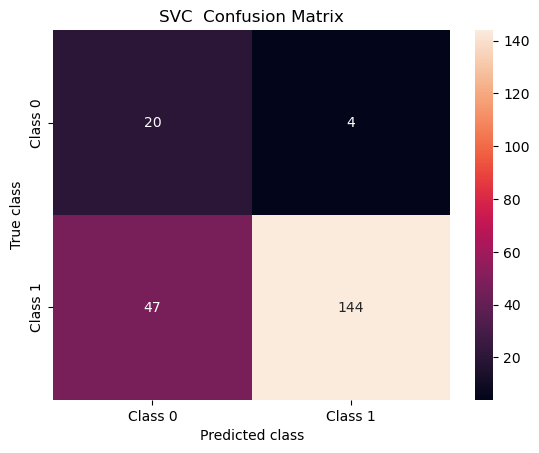

<Figure size 640x480 with 0 Axes>

Time: 59.2961220741272


In [57]:
svc(X_train, X_test, y_train, y_test)

MODEL  KNN 
KNN  Best Params: {'n_neighbors': 40, 'p': 1, 'weights': 'uniform'}
KNN  Training score with best params: 0.8914819136522754
KNN  Test score with best params: 0.8976744186046511
KNN  prediction metrics: 
              precision    recall  f1-score   support

           0       0.57      0.33      0.42        24
           1       0.92      0.97      0.94       191

    accuracy                           0.90       215
   macro avg       0.75      0.65      0.68       215
weighted avg       0.88      0.90      0.89       215

Cross-validation scores: [0.86713287 0.91608392 0.8951049  0.88111888 0.88811189 0.86619718]
Mean: 0.8856249384418398


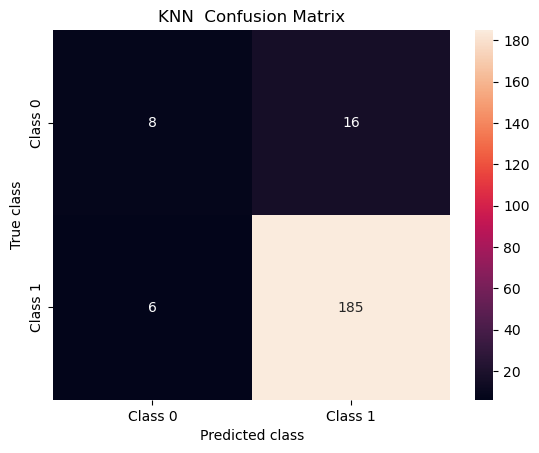

<Figure size 640x480 with 0 Axes>

Time: 0.7609758377075195


In [58]:
knn(X_train, X_test, y_train, y_test)

MODEL  Random Forest Classifier
Random Forest Classifier Best Params: {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 500}
Random Forest Classifier Training score with best params: 0.9813302217036173
Random Forest Classifier Test score with best params: 0.8930232558139535
Random Forest Classifier prediction metrics: 
              precision    recall  f1-score   support

           0       0.52      0.46      0.49        24
           1       0.93      0.95      0.94       191

    accuracy                           0.89       215
   macro avg       0.73      0.70      0.71       215
weighted avg       0.89      0.89      0.89       215

Cross-validation scores: [0.87412587 0.8951049  0.8951049  0.88111888 0.88111888 0.85915493]
Mean: 0.8809547260251486


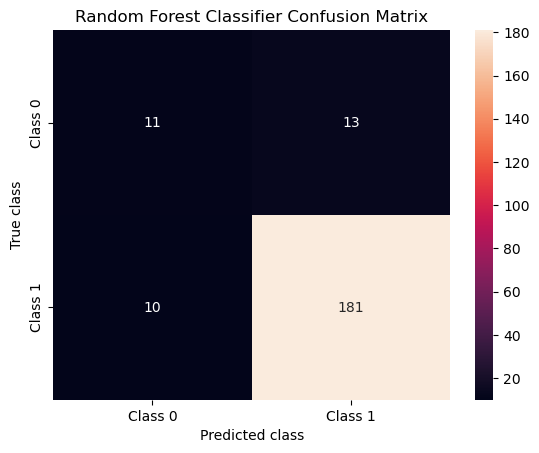

<Figure size 640x480 with 0 Axes>

Time: 159.08851313591003


In [59]:
rfc(X_train, X_test, y_train, y_test)

#### STANDARIZE AND PREDICTION MODELS


In [60]:
def standarize(X):
    return StandardScaler().fit(X).transform(X)

X_jordan_standarize = standarize(X_jordan)

In [61]:
x_t, x_v, y_t, y_v = train_test_split(X_jordan_standarize, y_jordan, train_size=0.8, random_state=40)

In [62]:
from sklearn.decomposition import PCA

pca = PCA(n_components=8)
pca.fit(X_jordan)
print(pca.score(X_jordan))

-13.38934283327351


MODEL  Logistic Regression
Logistic Regression Best Params: {'C': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}
Logistic Regression Training score with best params: 0.780630105017503
Logistic Regression Test score with best params: 0.7395348837209302
Logistic Regression prediction metrics: 
              precision    recall  f1-score   support

           0       0.28      0.83      0.42        24
           1       0.97      0.73      0.83       191

    accuracy                           0.74       215
   macro avg       0.62      0.78      0.62       215
weighted avg       0.89      0.74      0.79       215

Cross-validation scores: [0.70629371 0.83916084 0.82517483 0.72027972 0.76223776 0.77464789]
Mean: 0.7712991234117995


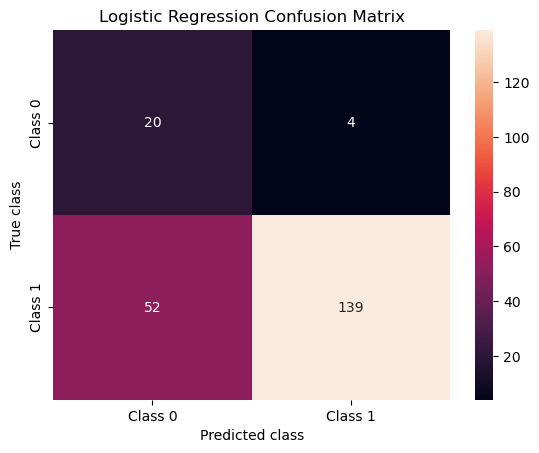

<Figure size 640x480 with 0 Axes>

Time: 1.6641321182250977


In [63]:
logisticRegression(x_t, x_v, y_t, y_v)

MODEL  SVC 
SVC  Best Params: {'C': 0.1, 'degree': 5, 'kernel': 'poly'}
SVC  Training score with best params: 0.8996499416569428
SVC  Test score with best params: 0.9116279069767442
SVC  prediction metrics: 
              precision    recall  f1-score   support

           0       0.62      0.54      0.58        24
           1       0.94      0.96      0.95       191

    accuracy                           0.91       215
   macro avg       0.78      0.75      0.76       215
weighted avg       0.91      0.91      0.91       215

Cross-validation scores: [0.76223776 0.82517483 0.81818182 0.75524476 0.78321678 0.77464789]
Mean: 0.7864506385633147


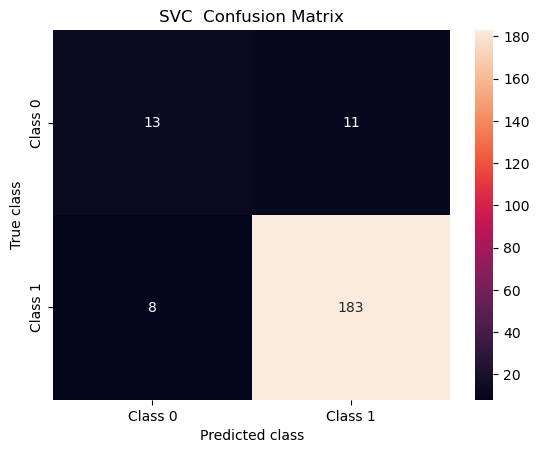

<Figure size 640x480 with 0 Axes>

Time: 46.39660048484802


In [64]:
svc(x_t, x_v, y_t, y_v)

MODEL  KNN 
KNN  Best Params: {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}
KNN  Training score with best params: 0.8984830805134189
KNN  Test score with best params: 0.9162790697674419
KNN  prediction metrics: 
              precision    recall  f1-score   support

           0       0.67      0.50      0.57        24
           1       0.94      0.97      0.95       191

    accuracy                           0.92       215
   macro avg       0.80      0.73      0.76       215
weighted avg       0.91      0.92      0.91       215

Cross-validation scores: [0.85314685 0.8951049  0.9020979  0.86013986 0.90909091 0.84507042]
Mean: 0.8774418070192717


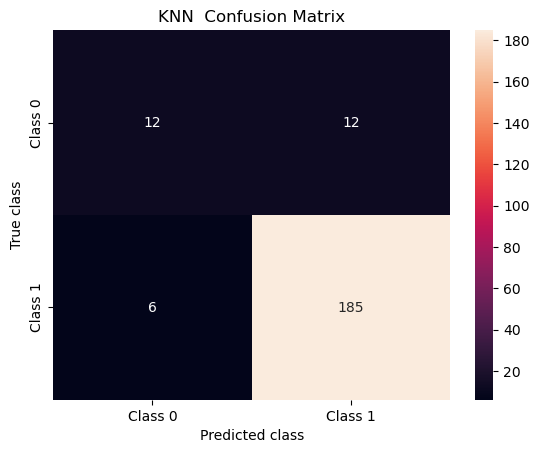

<Figure size 640x480 with 0 Axes>

Time: 0.6213746070861816


In [65]:
knn(x_t, x_v, y_t, y_v)

MODEL  Random Forest Classifier
Random Forest Classifier Best Params: {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'n_estimators': 500}
Random Forest Classifier Training score with best params: 0.9766627771295215
Random Forest Classifier Test score with best params: 0.8930232558139535
Random Forest Classifier prediction metrics: 
              precision    recall  f1-score   support

           0       0.52      0.50      0.51        24
           1       0.94      0.94      0.94       191

    accuracy                           0.89       215
   macro avg       0.73      0.72      0.73       215
weighted avg       0.89      0.89      0.89       215

Cross-validation scores: [0.88111888 0.90909091 0.9020979  0.87412587 0.88111888 0.86619718]
Mean: 0.8856249384418398


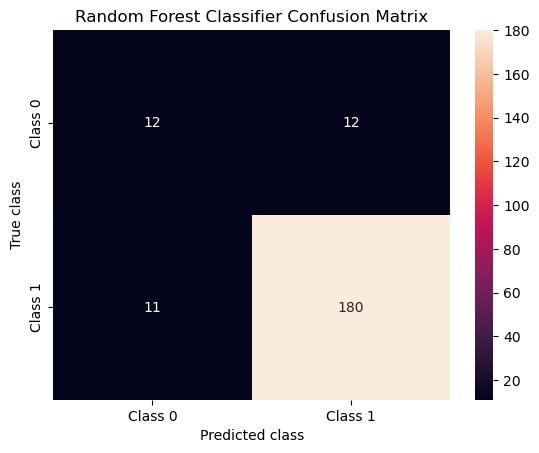

<Figure size 640x480 with 0 Axes>

Time: 157.1460280418396


In [66]:
rfc(x_t, x_v, y_t, y_v)